downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/ellipses/e1.jpg


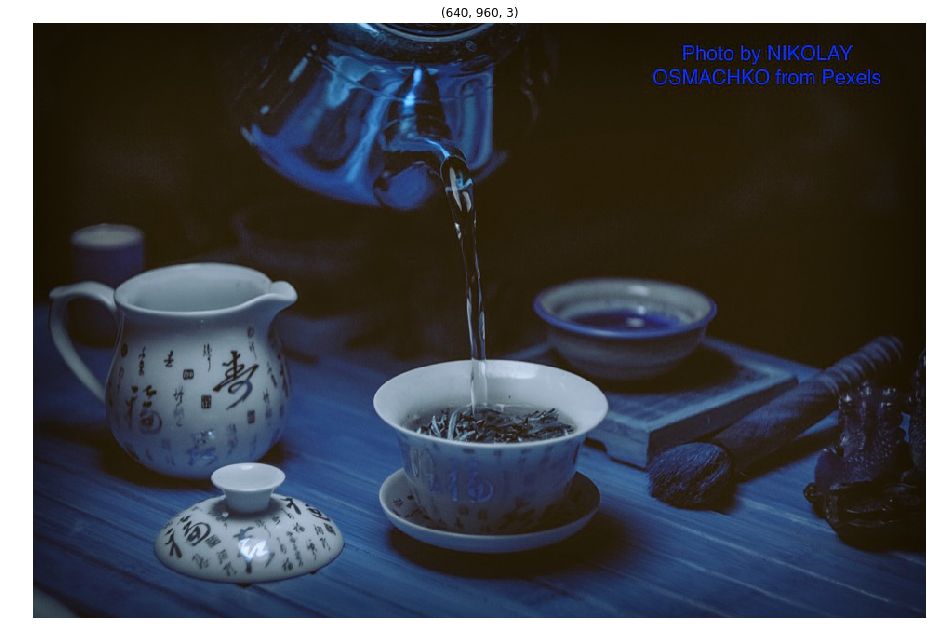

In [25]:
import cv2
import numpy as np
from math import *
from skimage import io
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['image.cmap'] = 'inferno'
# from google.colab.patches import cv2_imshow

def url_to_image(url):
  print("downloading %s" % (url))
  return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

url2 = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/ellipses/e1.jpg"
imgc = url_to_image(url2)

def imshow(img, cmap=None):
    plt.title(img.shape)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    
imshow(imgc)

# Restore ellipse

In [26]:
def get_E_matrice(points):
  m = np.zeros((len(points), len(points)))
  r = np.zeros((len(points), 1))

  for k in range(0, len(points)):
    m[k][0] = points[k][0]*points[k][0]
    m[k][1] = 2*points[k][0]*points[k][1]
    m[k][2] = points[k][1]*points[k][1]
    m[k][3] = 2*points[k][0]
    m[k][4] = 2*points[k][1]
    m[k][5] = 1

  mu, ms, mv = np.linalg.svd(m)

  p = mv[-1,:] #last column
  p /= p[0]

  E = np.array(
        [[p[0], p[1], p[3]],
        [p[1], p[2], p[4]],
        [p[3], p[4], p[5]] ], np.double )

#   print( "Ellipse " if E[0,0]*E[1,1]>E[0,1]*E[1,0] else "Not Ellipse!!!")
  if (E[0,0]*E[1,1]<=E[0,1]*E[1,0]):
    print("Not Ellipse!!!")
    return None
  
  return E

def get_H_matrice(E):
  u, s, v = np.linalg.svd(E)
  u2 = np.matmul(u, np.diag(np.sqrt(s)) )
  H = np.linalg.inv( u2.T)

  return H

def get_ellipse_points(H):
  points = np.zeros((360, 3))
  
  for alpha in range(len(points)):
    point = np.matmul( H, [[sin(pi*alpha/180)], [cos(pi*alpha/180)], [1]] ) 
    point/=point[2]
#     print(point)
    points[alpha] = point.transpose()
  return points

def restore_ellipse_from_points(img, points):
  E = get_E_matrice(points = points)

  if E is None:
    return None
  
  H = get_H_matrice(E)
  
  return get_ellipse_points(H)
  

In [27]:
img = imgc.copy()

initial_points = np.array([ [366, 407], [513, 363], [377, 426], [486, 456], [565, 449], [616,400] ], np.double)

ellipse_points = restore_ellipse_from_points(img = img, points = initial_points)

Draw restored ellipse


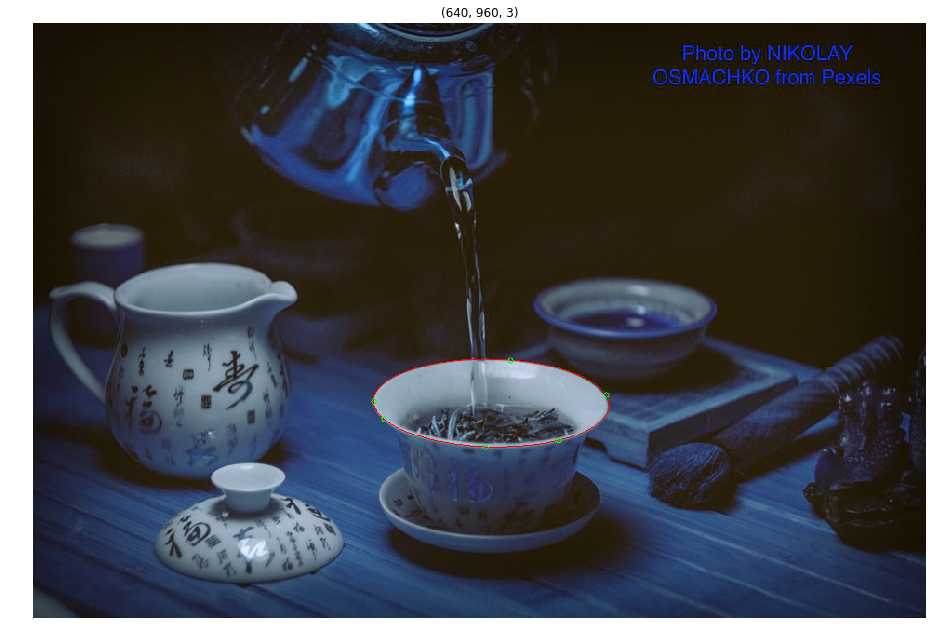

In [28]:
def draw_ellipse_from_points(img, init_points, ellipse_points):
  if ellipse_points is None:
    return
  
  for k in range(1, len(ellipse_points)):
    a1 = np.array(ellipse_points[k-1]).astype(int)
    a2 = np.array(ellipse_points[k]).astype(int)
    cv2.line(img, (a1[0],a1[1]), (a2[0],a2[1]), (255,0,0), 1)
    
  for k in range(0, len(init_points)):
    cv2.circle(img, (int(init_points[k][0]),int(init_points[k][1])),3,(0,255,0))

  imshow(img)

print("Draw restored ellipse")
draw_ellipse_from_points(img = img, init_points = initial_points, ellipse_points = ellipse_points)

# Build plot

In [29]:
img = imgc.copy()

# change sigma on normal dostribution from 0.0 to 10.0 with step 0.5
sigmas = np.arange(0.0,10.0,0.5)
norms_2 = np.zeros_like(sigmas)

max_norm = 0.0
max_norm_initial_poins = np.zeros_like(initial_points)
max_norm_ellipse_poins = np.zeros_like(ellipse_points)

i = 0
for sigma in sigmas:
  # add normal noise to initial 6 points
  noise_x = np.random.normal(0,sigma,len(initial_points))
  noise_y = np.random.normal(0,sigma,len(initial_points))
  noised_points = initial_points.copy()
  noised_points[:,0] += noise_x
  noised_points[:,1] += noise_y

  # restore ellipse from noised initial points
  noised_ellipse_points = restore_ellipse_from_points(img = img, points = noised_points)
  
  # check if it's not an ellipse
  if noised_ellipse_points is None:
    continue

  # get 2-norm of differences between ellipse restored from initial points and noised points
  norm_2 = np.linalg.norm(noised_ellipse_points-ellipse_points)
  norms_2[i] = norm_2
  i+=1
  
  if norm_2 > max_norm:
    max_norm = norm_2
    max_norm_initial_poins = noised_points
    max_norm_ellipse_poins = noised_ellipse_points
 

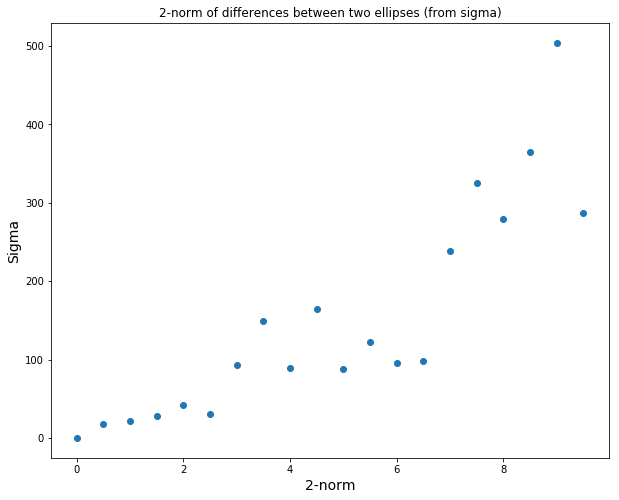

Draw ellipse with maximal error


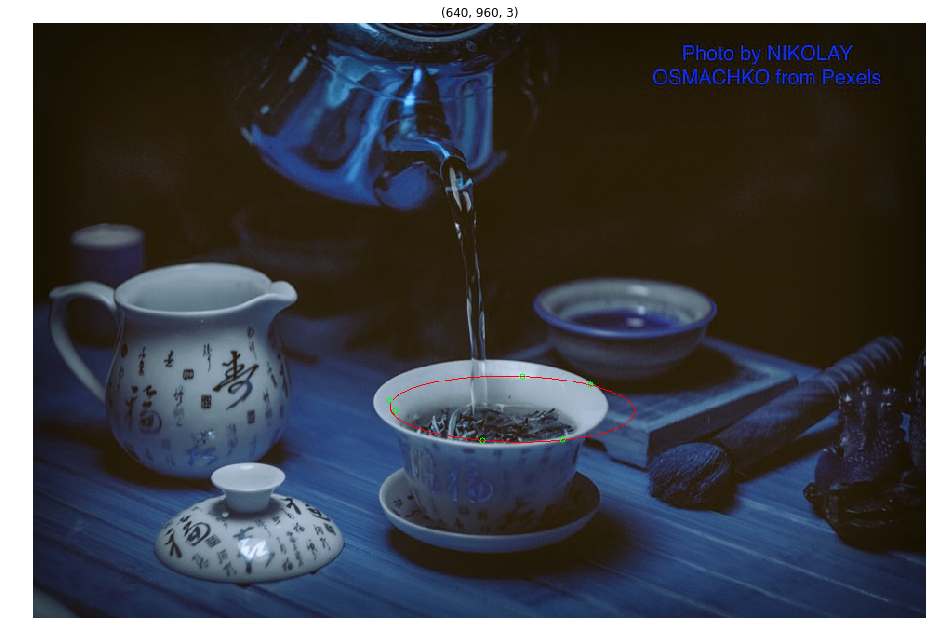

In [30]:
# draw plot
plt.figure(figsize=(10,8))
plt.title('2-norm of differences between two ellipses (from sigma)')
plt.xlabel('2-norm', fontsize=14, color='black')
plt.ylabel('Sigma', fontsize=14, color='black')
plt.scatter(sigmas, norms_2)
plt.show()

# draw ellipse with the biggest diffs
print("Draw ellipse with maximal error")
draw_ellipse_from_points(img = img, init_points = max_norm_initial_poins, ellipse_points = max_norm_ellipse_poins)